In [10]:
import pandas as pd
import openpyxl
hotelsdata = pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/hotels.xlsx").set_index('hotel')
hotelsdata


,Unnamed: 0,rooms,price
hotel,,,
hotel_1,0,13,273
hotel_2,1,18,92
hotel_3,2,12,141
hotel_4,3,18,157
hotel_5,4,7,298
...,...,...,...
hotel_396,395,5,212
hotel_397,396,12,68
hotel_398,397,14,102


In [11]:
guestdata = pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/guests.xlsx").set_index('guest')
guestdata

,Unnamed: 0,discount
guest,,
guest_1,0,0.09
guest_2,1,0.00
guest_3,2,0.07
guest_4,3,0.00
guest_5,4,0.10
...,...,...
guest_3996,3995,0.00
guest_3997,3996,0.15
guest_3998,3997,0.07


In [12]:
preferencesdata=pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/preferences.xlsx").drop_duplicates(subset=['guest','hotel'])
preferencesdata

,Unnamed: 0,guest,hotel,priority
0,0,guest_1,hotel_168,1
1,1,guest_1,hotel_207,2
2,2,guest_1,hotel_222,3
3,3,guest_1,hotel_124,4
4,4,guest_1,hotel_223,5
...,...,...,...,...
99528,99528,guest_4000,hotel_123,28
99529,99529,guest_4000,hotel_396,29
99530,99530,guest_4000,hotel_161,30
99531,99531,guest_4000,hotel_330,31


In [4]:
import numpy as np

In [5]:
preferencesdata.describe()

,Unnamed: 0,priority
count,95778.000000,95778.000000
mean,49749.808401,16.689647
std,28726.023375,11.598520
min,0.000000,1.000000
25%,24885.250000,7.000000
50%,49742.500000,15.000000
75%,74630.750000,25.000000
max,99532.000000,49.000000


In [6]:
guestdata.describe()

,Unnamed: 0,discount
count,4000.000000,4000.000000
mean,1999.500000,0.093948
std,1154.844867,0.058057
min,0.000000,0.000000
25%,999.750000,0.040000
50%,1999.500000,0.100000
75%,2999.250000,0.140000
max,3999.000000,0.190000


In [7]:
hotelsdata.describe()

,Unnamed: 0,rooms,price
count,400.000000,400.000000,400.000000
mean,199.500000,11.542500,177.645000
std,115.614301,4.387633,73.159379
min,0.000000,5.000000,50.000000
25%,99.750000,8.000000,116.750000
50%,199.500000,11.000000,183.000000
75%,299.250000,15.000000,238.250000
max,399.000000,19.000000,299.000000


In [8]:
preferencesdata.value_counts(subset=['guest','hotel'])

guest       hotel    
guest_1     hotel_1      1
guest_3392  hotel_55     1
guest_3393  hotel_100    1
guest_3392  hotel_94     1
            hotel_92     1
                        ..
guest_2179  hotel_216    1
            hotel_210    1
            hotel_21     1
            hotel_201    1
guest_999   hotel_43     1
Name: count, Length: 95778, dtype: int64

In [13]:
def calculate_satisfaction_percentage(guest_id, hotel_id, preferencesdata):
    guest_preferences = preferencesdata[preferencesdata['guest'] == guest_id].reset_index()


    if guest_preferences.empty:
        # No preferences, so 100% satisfaction
        return 100

    is_hotel_one_of_preferred = hotel_id in guest_preferences['hotel'].values

    if is_hotel_one_of_preferred:
        index_of_preference = guest_preferences['hotel'].eq(hotel_id).idxmax()
        guest_preferences_count = len(guest_preferences)
        return round(((guest_preferences_count - index_of_preference) / guest_preferences_count) * 100)
    else:
        # Guest settled for a not preferred hotel, so 0% satisfaction
        return 0

In [14]:
import matplotlib.pyplot as plt

def visualize_allocation(allocation):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Paid price sum for each hotel
    paid_price_by_hotel = allocation.groupby('hotel_id')['paid_price'].sum()
    paid_price_by_hotel.plot(kind='bar', ax=ax1, title='Paid Price Sum by Hotel')
    ax1.set_xlabel('Hotel ID')
    ax1.set_ylabel('Paid Price Sum')

    # Plot 2: Satisfaction percentage for each guest
    satisfaction_by_guest = allocation.groupby('guest_id')['satisfaction_percentage'].mean()
    satisfaction_by_guest.plot(kind='bar', ax=ax2, title='Satisfaction Percentage by Guest')
    ax2.set_xlabel('Guest ID')
    ax2.set_ylabel('Satisfaction Percentage')

    fig.suptitle(f"number of customers/rooms = {str(len(allocation))}; number of hotels = {str(allocation['hotel_id'].nunique())}")

    plt.tight_layout()
    plt.show()

In [7]:
import random

In [8]:
def allocate_random_hotel(guest_id, guest_row, hotelsdata, preferencesdata):
    available_hotels = hotelsdata[hotelsdata['rooms'] > 0]
    if available_hotels.empty:
        return None

    # randomly picking the hotel
    random_available_hotel_id = random.choice(available_hotels.index)
    # returning the row (aka the room)
    random_available_hotel_row = available_hotels.loc[random_available_hotel_id]
    # excluding the room from table of available rooms
    random_available_hotel_row['rooms'] -= 1

    paid_price_coefficient = 1 - guest_row['discount']
    paid_price = random_available_hotel_row['price'] * paid_price_coefficient

    satisfaction = calculate_satisfaction_percentage(guest_id, random_available_hotel_id, preferencesdata)

    return [guest_id, random_available_hotel_id, satisfaction, paid_price]

def get_random_allocation(hotelsdata, guestdata, preferencesdata):
    allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

    # randomizing guests
    shuffled_guests = guestdata.sample(frac=1, random_state=42)
    # we're taking every guest_id AND every pair guest_id|discount
    for guest_id, guest_row in shuffled_guests.iterrows():
        allocation_entry = allocate_random_hotel(guest_id, guest_row, hotelsdata, preferencesdata)
        if allocation_entry is not None:
            allocation.loc[len(allocation)] = allocation_entry

    return allocation

print('Start calculate random allocation')
random_allocation = get_random_allocation(hotelsdata.copy(), guestdata, preferencesdata)
visualize_allocation(random_allocation.head(20))

Start calculate random allocation


NameError: name 'hotelsdata' is not defined

In [9]:
def allocate_preferred_rooms(hotel_id, hotel_row, guestdata, preferencesdata, allocation):
    guests_who_preferred_hotel = preferencesdata[preferencesdata['hotel'] == hotel_id]['guest']
    #True when guest prefers hotel and he/she doesn't live anywhere at the moment, false - when they have a place to live => we have to exclude them.
    guests_to_allocate = guests_who_preferred_hotel[~guests_who_preferred_hotel.isin(allocation['guest_id'])]

    hotel_available_rooms = hotel_row['rooms']

    for _, guest_id in guests_to_allocate.items():
        if hotel_available_rooms == 0:
            break

        hotel_available_rooms -= 1

        guest_row = guestdata.loc[guest_id]

        paid_price_coefficient = 1 - guest_row['discount']
        paid_price = hotel_row['price'] * paid_price_coefficient

        satisfaction = calculate_satisfaction_percentage(guest_id, hotel_id, preferencesdata)

        allocation.loc[len(allocation)] = [guest_id, hotel_id, satisfaction, paid_price]

    return hotel_available_rooms, allocation


def allocate_remaining_rooms(hotel_available_rooms, hotel_id, hotel_row, guestdata, allocation):
    guests_to_allocate = guestdata[~guestdata.index.isin(allocation['guest_id'])]

    for guest_id, guest_row in guests_to_allocate.iterrows():
        if hotel_available_rooms == 0:
            break

        hotel_available_rooms -= 1

        paid_price_coefficient = 1 - guest_row['discount']
        paid_price = hotel_row['price'] * paid_price_coefficient

        allocation.loc[len(allocation)] = [guest_id, hotel_id, 0, paid_price]

    return allocation

def get_availability_allocation(hotelsdata, guestdata, preferencesdata):
    allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

    sorted_hotels = hotelsdata.sort_values(by='rooms', ascending=False)

    for hotel_id, hotel_row in sorted_hotels.iterrows():
        hotel_remaining_rooms_count, allocation = allocate_preferred_rooms(hotel_id, hotel_row, guestdata, preferencesdata, allocation)
        if hotel_remaining_rooms_count > 0:
            allocation = allocate_remaining_rooms(hotel_remaining_rooms_count,  hotel_id, hotel_row, guestdata, allocation)

    return allocation

print('Start calculate availability allocation')
availability_allocation = get_availability_allocation(hotelsdata, guestdata, preferencesdata)
visualize_allocation(availability_allocation.head(20))

Start calculate availability allocation


NameError: name 'hotelsdata' is not defined

Start calculate preference allocation


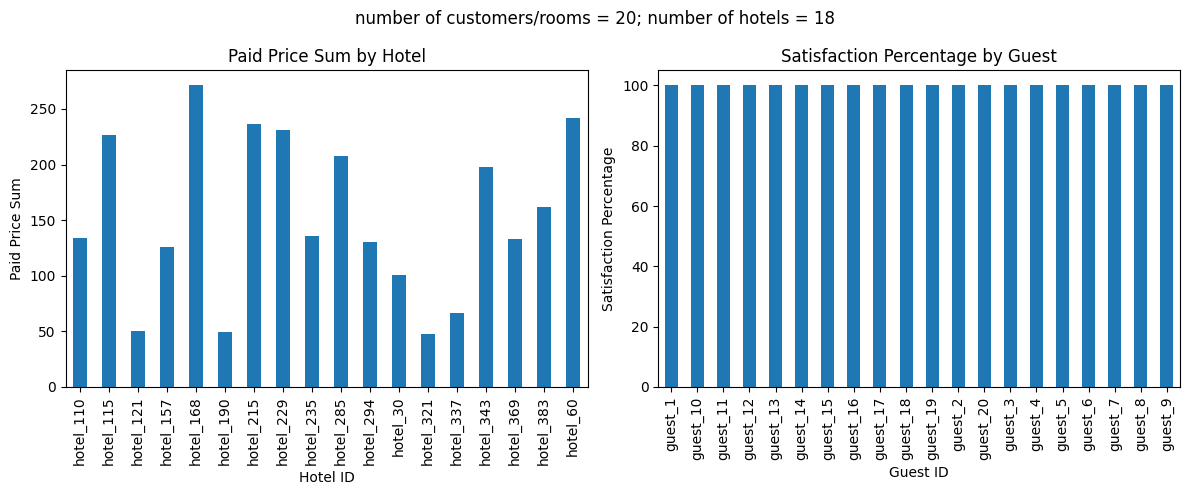

In [24]:
def allocate_preferred_hotel(guest_id, guest_row, hotelsdata, preferencesdata):
    #dictionary, where we turn the table into dictionary
    guest_preferred_hotels = preferencesdata[preferencesdata['guest'] == guest_id]['hotel']
    for _, preferred_hotel_id in guest_preferred_hotels.items():
        #we returning the row of a matrix
        preferred_hotel_row = hotelsdata.loc[preferred_hotel_id]
        

        if preferred_hotel_row['rooms'] > 0:
            preferred_hotel_row['rooms'] -= 1

            paid_price_coefficient = 1 - guest_row['discount']
            paid_price = preferred_hotel_row['price'] * paid_price_coefficient

            satisfaction = calculate_satisfaction_percentage(guest_id, preferred_hotel_id, preferencesdata)

            return [guest_id, preferred_hotel_id, satisfaction, paid_price]

    return None


def get_customer_preference_allocation(hotelsdata, guestdata, preferencesdata):
    allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

    for guest_id, guest_row in guestdata.iterrows():
        allocation_entry = allocate_preferred_hotel(guest_id, guest_row, hotelsdata, preferencesdata)
        if allocation_entry is not None:
            allocation.loc[len(allocation)] = allocation_entry

    return allocation

print('Start calculate preference allocation')
customer_preference_allocation = get_customer_preference_allocation(hotelsdata, guestdata, preferencesdata)
visualize_allocation(customer_preference_allocation.head(20))

Start calculate price allocation


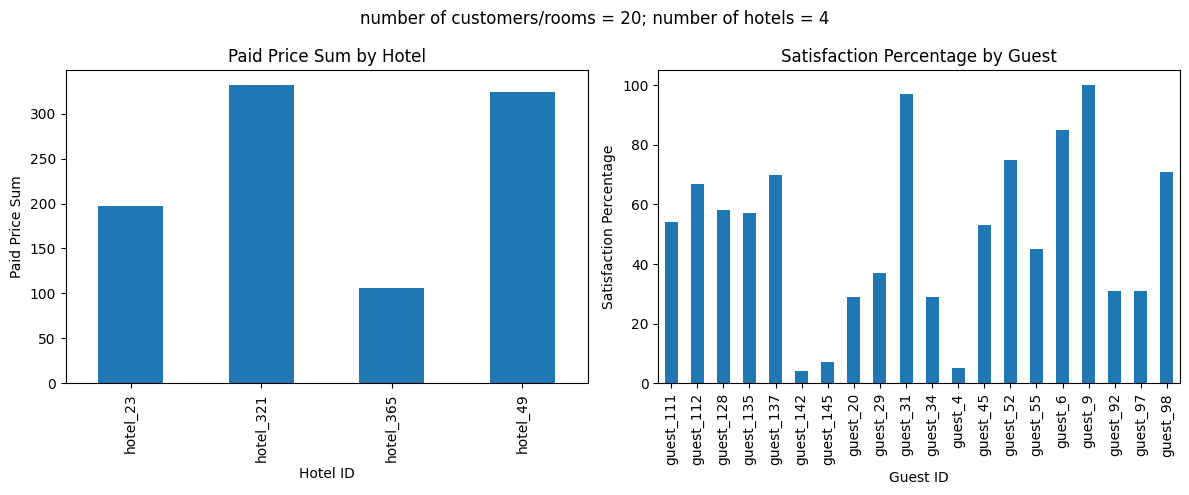

In [25]:
def allocate_preferred_rooms(hotel_id, hotel_row, guestdata, preferencesdata, allocation):
    #dictionary where we assigning hotels to a guests, all guests who prefer this hotel
    guests_who_preferred_hotel = preferencesdata[preferencesdata['hotel'] == hotel_id]['guest']
    guests_to_allocate = guests_who_preferred_hotel[~guests_who_preferred_hotel.isin(allocation['guest_id'])]
    # as well
    hotel_available_rooms = hotel_row['rooms']

    for _, guest_id in guests_to_allocate.items():
        if hotel_available_rooms == 0:
            break
        #excluding one room
        hotel_available_rooms -= 1
        #returning the row according to a guest id
        guest_row = guestdata.loc[guest_id]

        paid_price_coefficient = 1 - guest_row['discount']
        paid_price = hotel_row['price'] * paid_price_coefficient

        satisfaction = calculate_satisfaction_percentage(guest_id, hotel_id, preferencesdata)
        #output
        allocation.loc[len(allocation)] = [guest_id, hotel_id, satisfaction, paid_price]

    return hotel_available_rooms, allocation


def allocate_remaining_rooms(hotel_available_rooms, hotel_id, hotel_row, guestdata, allocation):
    guests_to_allocate = guestdata[~guestdata.index.isin(allocation['guest_id'])]
    for guest_id, guest_row in guests_to_allocate.iterrows():
        if hotel_available_rooms == 0:
            break

        hotel_available_rooms -= 1

        paid_price_coefficient = 1 - guest_row['discount']
        paid_price = hotel_row['price'] * paid_price_coefficient

        allocation.loc[len(allocation)] = [guest_id, hotel_id, 0, paid_price]

    return allocation


def get_price_allocation(hotelsdata, guestdata, preferencesdata):
    allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

    sorted_hotels = hotelsdata.sort_values(by='price')
    #for every index and every row
    for hotel_id, hotel_row in sorted_hotels.iterrows():
        hotel_remaining_rooms_count, allocation = allocate_preferred_rooms(hotel_id, hotel_row, guestdata, preferencesdata, allocation)
        if hotel_remaining_rooms_count > 0:
            allocation = allocate_remaining_rooms(hotel_remaining_rooms_count,  hotel_id, hotel_row, guestdata, allocation)

    return allocation

print('Start calculate price allocation')
price_allocation = get_price_allocation(hotelsdata, guestdata, preferencesdata)
visualize_allocation(price_allocation.head(20))

In [16]:
import pandas as pd
import random

class RandomHotelAllocator:
    def __init__(self, hotelsdata, guestdata, preferencesdata):
        self.hotelsdata = hotelsdata
        self.guestdata = guestdata
        self.preferencesdata = preferencesdata
        self.allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

    def allocate_random_hotel(self, guest_id, guest_row):
        available_hotels = self.hotelsdata[self.hotelsdata['rooms'] > 0]
        if available_hotels.empty:
            return None

        random_available_hotel_id = random.choice(available_hotels.index)
        random_available_hotel_row = available_hotels.loc[random_available_hotel_id]
        random_available_hotel_row['rooms'] -= 1

        paid_price_coefficient = 1 - guest_row['discount']
        paid_price = random_available_hotel_row['price'] * paid_price_coefficient

        satisfaction = self.calculate_satisfaction_percentage(guest_id, random_available_hotel_id)

        return [guest_id, random_available_hotel_id, satisfaction, paid_price]

    def get_random_allocation(self):
        shuffled_guests = self.guestdata.sample(frac=1, random_state=42)
        for guest_id, guest_row in shuffled_guests.iterrows():
            allocation_entry = self.allocate_random_hotel(guest_id, guest_row)
            if allocation_entry is not None:
                self.allocation.loc[len(self.allocation)] = allocation_entry

        return self.allocation

In [17]:
def allocation_analysis(allocation):
    print('Customers accomodated:', allocation['guest_id'].count())
    #it should be the same :)
    print('Number of rooms occupied:', allocation['guest_id'].count())
    print('Number of different hotels occupied:', allocation['hotel_id'].nunique())
    print('Average satisfaction:', round(allocation['satisfaction_percentage'].mean(),2))
    total_earnings = allocation[['hotel_id', 'paid_price']].copy()
    print('Total earnings per hotel:', total_earnings.groupby('hotel_id').sum(), sep='\n')

In [18]:
print('Start calculate random allocation')
r_allocator = RandomHotelAllocator(hotelsdata.copy(), guestdata, preferencesdata)
random_allocation = r_allocator.get_random_allocation()
allocation_analysis(random_allocation)
visualize_allocation(random_allocation.head(20))

Start calculate random allocation


AttributeError: 'RandomHotelAllocator' object has no attribute 'calculate_satisfaction_percentage'